In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import os
import shutil
import subprocess
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import h2o

In [2]:
project_name = 'Dbeaver'
version_name = '21.1.0'

project_name = 'Redisson'
version_name = 'redisson-3.16.0'

n_cluster_divisible_arr = [5,7,10,15,20,25]
affinity_arr = ['euclidean', 'manhattan', 'cosine']
linkage_arr = ['complete', 'average', 'single']

n_cluster = 300
affinity = 'cosine'
linkage = 'single'

In [3]:
depends_dir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_depends/{project_name}/{project_name}_{version_name}.json'
rootdir = f'C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}'

In [4]:
print(rootdir)

C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/Redisson/Redisson_redisson-3.16.0


In [5]:
full_dir_arr = []
for root, dirs, files in os.walk(rootdir):
    #print(root)
    #print(dirs)
    for element in files:
        if '.java' in element:
            dir_string = root + '\\' + element
            full_dir_arr.append(dir_string)

cluster_dict = {}
cluster_tree = {}


for element in full_dir_arr:
    element = element.split('\\')
    child = element[-1]
    parent = element[-2]
    cluster_tree[child] = parent

In [6]:
cluster_tree

{'ElementsSubscribeService.java': 'redisson',
 'JndiRedissonFactory.java': 'redisson',
 'MapWriteBehindTask.java': 'redisson',
 'MapWriterTask.java': 'redisson',
 'PubSubEntry.java': 'handler',
 'PubSubMessageListener.java': 'redisson',
 'PubSubPatternMessageListener.java': 'redisson',
 'PubSubPatternStatusListener.java': 'redisson',
 'PubSubStatusListener.java': 'redisson',
 'QueueTransferService.java': 'redisson',
 'QueueTransferTask.java': 'redisson',
 'RedisClusterNodes.java': 'redisson',
 'RedisNodes.java': 'redisnode',
 'Redisson.java': 'redisson',
 'RedissonAtomicDouble.java': 'redisson',
 'RedissonAtomicLong.java': 'redisson',
 'RedissonBaseAdder.java': 'redisson',
 'RedissonBaseLock.java': 'redisson',
 'RedissonBatch.java': 'redisson',
 'RedissonBinaryStream.java': 'redisson',
 'RedissonBitSet.java': 'redisson',
 'RedissonBlockingDeque.java': 'redisson',
 'RedissonBlockingQueue.java': 'redisson',
 'RedissonBloomFilter.java': 'redisson',
 'RedissonBoundedBlockingQueue.java': 'r

In [7]:
len(cluster_tree)

1295

In [164]:
try:
    os.mkdir('raw_depends/' + project_name)
except:
    pass

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & ' + f"java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/{project_name}/{project_name}_{version_name}" +  f' ../raw_depends/{project_name}/{project_name}_{version_name}' 
print(command)
os.system(command)

cd C:/Users/tanji/Desktop/SoftwareRemodularization/depends-0.9.2 & java -jar depends.jar java C:/Users/tanji/Desktop/SoftwareRemodularization/raw_sourcecode/Redisson/Redisson_redisson-3.16.0 ../raw_depends/Redisson/Redisson_redisson-3.16.0


0

In [8]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

1849


In [9]:
with open(depends_dir) as f:
    depends_results = json.load(f)
    index  = 0
    var_array = []
    print(len(depends_results['variables']))
    print(len(depends_results['cells']))
    for value in depends_results['variables']:
        var_array.append([index, value.split('\\')[-1]])
        #print(index, value)
        index += 1

    var_df = pd.DataFrame(var_array)
    var_df.columns = ['index_val', 'name']

    feature_list = {}
    feature_index = 2
    for element in depends_results['cells']:
        #print(element)
        try:
            for a in element['values']:
                if a not in feature_list:
                    feature_list[a] = feature_index
                    feature_index += 1
                #print(a['Call'])


        except:
            pass

    feature_arr = []
    for element in depends_results['cells']:
        #print(array)
        array = [0] * (len(feature_list) + 2)
        values = dict(element['values'])
        #print(element)
        array[0] = element['src']
        array[1] = element['dest']
        for feature in feature_list:
            try:
                value = values[feature]
                array[feature_list[feature]] = value
            except:
                pass
        #print(array)
        feature_arr.append(array)

    feature_df = pd.DataFrame(feature_arr)
    col_names = ['src', 'dest']
    for element in feature_list:
        col_names.append(element)
    feature_df.columns = col_names

    feature_df['sum'] = feature_df.sum(axis=1) - feature_df['src'] - feature_df['dest']
    #G = nx.Graph()
    G = nx.path_graph(len(depends_results['variables']))
    for index, row in feature_df.iterrows():
        G.add_edge(row['src'], row['dest'], weight=row['sum'])

    adj_mat = nx.adjacency_matrix(G)
    adj_mat_df = pd.DataFrame(adj_mat.toarray())
    np.fill_diagonal(adj_mat_df.values, adj_mat_df.values.max())
    x = adj_mat_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    adj_mat_df = pd.DataFrame(x_scaled)
    
    sum_dependency_df = nx.to_pandas_adjacency(G)
    sum_dependency_df['sum'] = sum_dependency_df.sum(axis=1)
    final_dependency_df = sum_dependency_df['sum']

1849
32182


In [10]:
final_dependency_df

0       10.0
1       26.0
2        7.0
3       80.0
4        3.0
        ... 
1844    76.0
1845    32.0
1846     9.0
1847    66.0
1848    39.0
Name: sum, Length: 1849, dtype: float64

In [11]:
adj_mat_df

,0,1,2,3,4,5,6,7,8,9,...,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848
0,1.00000,0.00189,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.00189,1.00000,0.00189,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00189,1.00000,0.00189,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00189,1.00000,0.00189,0.00189,0.00189,0.00189,0.00189,0.00189,...,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00189,1.00000,0.00189,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1844,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.00189,1.00000,0.00189,0.00000,0.00000,0.00000
1845,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00189,0.0,0.0,0.00000,0.00189,1.00000,0.00189,0.00000,0.00000
1846,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00189,0.0,0.0,0.00000,0.00000,0.00189,1.00000,0.00189,0.00000
1847,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00189,1.00000,0.00189


In [12]:
feature_df

,src,dest,Import,Use,Call,Parameter,Contain,Return,Create,Implement,Cast,Throw,Extend,Annotation,sum
0,288,1703,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,288,1702,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,288,1705,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,288,1704,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,288,1701,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32177,1569,932,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32178,748,820,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32179,1569,931,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32180,1569,934,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
print('Currently processing: ' + project_name + version_name)
command = f'java -jar ck-0.3.3-SNAPSHOT-jar-with-dependencies.jar raw_sourcecode/{project_name}/{project_name}_{version_name}'
print(command)
os.system(command)
os.rename('class.csv', project_name + '_' + version_name + '_class.csv')
os.rename('field.csv',  project_name + '_' + version_name + '_field.csv')
os.rename('method.csv', project_name + '_' + version_name + '_method.csv')

shutil.move(project_name + '_' + version_name + '_class.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_class.csv')
shutil.move(project_name + '_' + version_name + '_field.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_field.csv')
shutil.move(project_name + '_' + version_name + '_method.csv', 'ck_results_invi/' + project_name + '_' + version_name + '_method.csv')

          

Currently processing: Redissonredisson-3.16.0
java -jar ck-0.3.3-SNAPSHOT-jar-with-dependencies.jar raw_sourcecode/Redisson/Redisson_redisson-3.16.0


'ck_results_invi/Redisson_redisson-3.16.0_method.csv'

In [13]:
try:
    os.mkdir('MoJo_1.2.1/' + project_name)
except:
    pass

In [14]:
cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
cluster_result = cluster.fit_predict(adj_mat_df)

ck_metrics = pd.read_csv(f'ck_results_invi/{project_name}_{version_name}_class.csv')
ck_metrics['class_name'] = ck_metrics['file'].str.split('\\').str[-1]
filename_a = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_a.rsf'
filename_b = 'C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1/' + project_name + '/' + project_name + '_' + version_name + '_' + str(n_cluster) + '_' +str(affinity) + '_' + str(linkage) + '_b.rsf'

with open(filename_a, 'w') as f:
    for key, value in cluster_tree.items():
        f.write('contain ' + str(value).replace(" ",'') + ' ' + str(key).replace(' ','') + '\n')

arr_a_rsf = []
arr_b_rsf = []
with open(filename_b, 'w') as f:
    len_b_rsf = 0
    duplicate_array = []
    refactor_arr = []
    main_data_arr = []
    clustering_result_dict = {}
    num_line_affected = 0
    num_dependency = 0
    actual_num_of_classes_touched = 0
    for i in range(len(cluster_result)):
        try:
            subject = var_df[var_df['index_val'] == i]['name'].values[0]
            print(subject)
            #print(subject in cluster_tree)
            if subject in cluster_tree and subject not in duplicate_array:
                print(element)
                duplicate_array.append(subject)
                string = "contain " + str(cluster_result[i]) + " " + subject + "\n"
                arr_b_rsf.append(subject)
                len_b_rsf += 1
                f.write(string)
                #print(subject)
                class_metrics = ck_metrics.loc[ck_metrics['class_name'] == subject].values.tolist()[0]
                
                #print(ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0])
                
                subjected_file = ck_metrics.loc[ck_metrics['class_name'] == subject]['file'].values[0]
                
                #print(subjected_file)
                
                num_dependency = final_dependency_df.iloc[cluster_result[i]]
                num_line_affected += sum(1 for line in open(subjected_file))
                
                
                class_metrics.append(num_dependency)
                class_metrics.append(num_line_affected)
                main_data_arr.append(class_metrics)
                
                
                ## Important
                ## This is assuming that during Depends, the file structure is already sorted
                ## I.e. going through the directory structure depth wise, not breath wise
                original_parent = cluster_tree[subject]
                try:
                    to_check_parent = clustering_result_dict[cluster_result[i]]
                    print(original_parent, to_check_parent)
                    if original_parent != to_check_parent:
                        refactor_arr.append(f'Move {subject} to {str(cluster_result[i])}')
                        actual_num_of_classes_touched += 1
                    
                    clustering_result_dict[cluster_result[i]] = to_check_parent
                except:
                    clustering_result_dict[cluster_result[i]] = original_parent
                
            else:
                #print(subject)
                pass
        except Exception as e:
            print(e)
            pass
f.close()

command = 'cd C:/Users/tanji/Desktop/SoftwareRemodularization/MoJo_1.2.1 & ' + 'java MoJo ' + filename_a + ' ' + filename_b + ' >> ' + project_name + '/' + project_name + '_results.txt'
#print(command)
os.system(command)

RedissonExtension.java
Annotation
RedissonExtensionTest.java
Annotation
redisson helidon
JndiRedissonRegionFactory.java
Annotation
hibernate helidon
RedissonRegionFactory.java
Annotation
hibernate helidon
RedissonStrategyRegistrationProvider.java
Annotation
BaseRegion.java
Annotation
region helidon
RedissonCollectionRegion.java
Annotation
region helidon
RedissonEntityRegion.java
Annotation
region helidon
RedissonNaturalIdRegion.java
Annotation
region helidon
RedissonQueryRegion.java
Annotation
region helidon
RedissonTimestampsRegion.java
Annotation
region helidon
AbstractReadWriteAccessStrategy.java
Annotation
strategy helidon
BaseRegionAccessStrategy.java
Annotation
NonStrictReadWriteCollectionRegionAccessStrategy.java
Annotation
strategy helidon
NonStrictReadWriteEntityRegionAccessStrategy.java
Annotation
strategy helidon
NonStrictReadWriteNaturalIdRegionAccessStrategy.java
Annotation
strategy helidon
ReadOnlyCollectionRegionAccessStrategy.java
Annotation
strategy helidon
ReadOnlyEnt

RedisRunner.java
RedisVersion.java
RedissonRuntimeEnvironment.java
BaseConnectionTest.java
RedissonClusterConnectionRenameTest.java
Annotation
connection helidon
RedissonClusterConnectionTest.java
Annotation
connection helidon
RedissonConnectionTest.java
RedissonMultiConnectionTest.java
RedissonPipelineConnectionTest.java
RedissonSentinelConnectionTest.java
RedissonSubscribeTest.java
BinaryConvertor.java
DataTypeConvertor.java
DistanceConvertor.java
GeoResultsDecoder.java
Annotation
ObjectListReplayDecoder2.java
PointDecoder.java
PropertiesDecoder.java
RedisClusterNodeDecoder.java
RedissonClusterConnection.java
RedissonConnection.java
RedissonConnectionFactory.java
RedissonExceptionConverter.java
RedissonSentinelConnection.java
RedissonSubscription.java
ScoredSortedListReplayDecoder.java
ScoredSortedSetReplayDecoder.java
SecondsConvertor.java
SetReplayDecoder.java
BaseTest.java
ClusterRunner.java
RedisRunner.java
RedisVersion.java
RedissonRuntimeEnvironment.java
BaseConnectionTest.java

RedisClusterNodeDecoder.java
RedissonBaseCommands.java
RedissonBaseReactive.java
RedissonClusterConnection.java
RedissonConnection.java
RedissonConnectionFactory.java
RedissonExceptionConverter.java
RedissonReactiveClusterGeoCommands.java
RedissonReactiveClusterHashCommands.java
RedissonReactiveClusterHyperLogLogCommands.java
RedissonReactiveClusterKeyCommands.java
RedissonReactiveClusterListCommands.java
RedissonReactiveClusterNumberCommands.java
RedissonReactiveClusterServerCommands.java
RedissonReactiveClusterSetCommands.java
RedissonReactiveClusterStreamCommands.java
RedissonReactiveClusterStringCommands.java
RedissonReactiveClusterZSetCommands.java
RedissonReactiveGeoCommands.java
RedissonReactiveHashCommands.java
RedissonReactiveHyperLogLogCommands.java
RedissonReactiveKeyCommands.java
RedissonReactiveListCommands.java
RedissonReactiveNumberCommands.java
RedissonReactivePubSubCommands.java
RedissonReactiveRedisClusterConnection.java
RedissonReactiveRedisConnection.java
RedissonRe

MapWriteBehindTask.java
Annotation
redisson helidon
MapWriterTask.java
Annotation
redisson helidon
PubSubEntry.java
Annotation
PubSubMessageListener.java
Annotation
redisson helidon
PubSubPatternMessageListener.java
Annotation
redisson helidon
PubSubPatternStatusListener.java
Annotation
redisson helidon
PubSubStatusListener.java
Annotation
redisson helidon
QueueTransferService.java
Annotation
redisson helidon
QueueTransferTask.java
Annotation
redisson helidon
RedisClusterNodes.java
Annotation
RedisNodes.java
Annotation
redisnode helidon
Redisson.java
Annotation
redisson helidon
RedissonAtomicDouble.java
Annotation
redisson helidon
RedissonAtomicLong.java
Annotation
redisson helidon
RedissonBaseAdder.java
Annotation
redisson helidon
RedissonBaseLock.java
Annotation
redisson helidon
RedissonBatch.java
Annotation
redisson helidon
RedissonBinaryStream.java
Annotation
redisson helidon
RedissonBitSet.java
Annotation
redisson helidon
RedissonBlockingDeque.java
Annotation
redisson helidon
Redi

RCollectionRx.java
Annotation
api helidon
RCountDownLatch.java
Annotation
api helidon
RCountDownLatchAsync.java
Annotation
api helidon
RCountDownLatchReactive.java
Annotation
RCountDownLatchRx.java
Annotation
RDelayedQueue.java
Annotation
api helidon
RDeque.java
Annotation
api helidon
RDequeAsync.java
Annotation
api helidon
RDequeReactive.java
Annotation
api helidon
RDequeRx.java
Annotation
api helidon
RDestroyable.java
Annotation
api helidon
RDoubleAdder.java
Annotation
api helidon
RExecutorBatchFuture.java
Annotation
api helidon
RExecutorFuture.java
Annotation
api helidon
RExecutorService.java
Annotation
api helidon
RExecutorServiceAsync.java
Annotation
api helidon
RExpirable.java
Annotation
api helidon
RExpirableAsync.java
Annotation
api helidon
RExpirableReactive.java
Annotation
api helidon
RExpirableRx.java
Annotation
api helidon
RFuture.java
Annotation
api helidon
RGeo.java
Annotation
api helidon
RGeoAsync.java
Annotation
api helidon
RGeoReactive.java
Annotation
api helidon
RGeoR

executor helidon
TaskStartedListener.java
Annotation
executor helidon
TaskSuccessListener.java
Annotation
BaseGeoSearch.java
Annotation
geo helidon
BaseOptionalGeoSearch.java
Annotation
geo helidon
GeoSearchArgs.java
Annotation
geo helidon
GeoSearchNode.java
Annotation
geo helidon
OptionalGeoSearch.java
Annotation
geo helidon
ShapeGeoSearch.java
Annotation
geo helidon
BasePatternStatusListener.java
Annotation
listener helidon
BaseStatusListener.java
Annotation
listener helidon
ListAddListener.java
Annotation
listener helidon
ListInsertListener.java
Annotation
ListRemoveListener.java
Annotation
ListSetListener.java
Annotation
ListTrimListener.java
Annotation
MessageListener.java
Annotation
listener helidon
PatternMessageListener.java
Annotation
listener helidon
PatternStatusListener.java
Annotation
listener helidon
ScoredSortedSetAddListener.java
Annotation
listener helidon
SetObjectListener.java
Annotation
listener helidon
StatusListener.java
Annotation
listener helidon
MapLoader.java


convertor helidon
EmptyMapConvertor.java
Annotation
EmptySetConvertor.java
Annotation
IntegerReplayConvertor.java
Annotation
convertor helidon
LongReplayConvertor.java
Annotation
NumberConvertor.java
Annotation
convertor helidon
ShortReplayConvertor.java
Annotation
StreamIdConvertor.java
Annotation
convertor helidon
StringToListConvertor.java
Annotation
TimeObjectDecoder.java
Annotation
convertor helidon
TrueReplayConvertor.java
Annotation
TypeConvertor.java
Annotation
convertor helidon
VoidReplayConvertor.java
Annotation
convertor helidon
AutoClaimDecoder.java
Annotation
decoder helidon
ClusterNodesDecoder.java
Annotation
decoder helidon
CodecDecoder.java
Annotation
decoder helidon
FastAutoClaimDecoder.java
Annotation
decoder helidon
GeoDistanceDecoder.java
Annotation
decoder helidon
GeoPositionDecoder.java
Annotation
decoder helidon
GeoPositionMapDecoder.java
Annotation
decoder helidon
InetSocketAddressDecoder.java
Annotation
decoder helidon
KeyValueMessage.java
Annotation
ListFirstO

MapCacheEvictionTask.java
Annotation
eviction helidon
MultimapEvictionTask.java
Annotation
eviction helidon
ScoredSetEvictionTask.java
Annotation
eviction helidon
TimeSeriesEvictionTask.java
Annotation
eviction helidon
CronExpression.java
Annotation
executor helidon
RedissonClassLoader.java
Annotation
executor helidon
RedissonCompletionService.java
Annotation
executor helidon
RedissonExecutorBatchFuture.java
Annotation
executor helidon
RedissonExecutorFuture.java
Annotation
executor helidon
RedissonExecutorFutureReference.java
Annotation
executor helidon
RedissonExecutorRemoteService.java
Annotation
executor helidon
RedissonScheduledFuture.java
Annotation
executor helidon
RemoteExecutorService.java
Annotation
executor helidon
RemoteExecutorServiceAsync.java
Annotation
executor helidon
RemotePromise.java
Annotation
executor helidon
ScheduledTasksService.java
Annotation
executor helidon
TasksBatchService.java
Annotation
executor helidon
TasksRunnerService.java
Annotation
executor helidon

Annotation
rx helidon
RedissonBlockingDequeRx.java
Annotation
rx helidon
RedissonBlockingQueueRx.java
Annotation
rx helidon
RedissonKeysRx.java
Annotation
rx helidon
RedissonLexSortedSetRx.java
Annotation
rx helidon
RedissonListMultimapCacheRx.java
Annotation
rx helidon
RedissonListMultimapRx.java
Annotation
rx helidon
RedissonListRx.java
Annotation
rx helidon
RedissonMapCacheRx.java
Annotation
rx helidon
RedissonMapRx.java
Annotation
rx helidon
RedissonMapRxIterator.java
Annotation
rx helidon
RedissonReadWriteLockRx.java
Annotation
rx helidon
RedissonReliableTopicRx.java
Annotation
rx helidon
RedissonScoredSortedSetRx.java
Annotation
rx helidon
RedissonSetCacheRx.java
Annotation
rx helidon
RedissonSetMultimapCacheRx.java
Annotation
rx helidon
RedissonSetMultimapRx.java
Annotation
rx helidon
RedissonSetRx.java
Annotation
rx helidon
RedissonTimeSeriesRx.java
Annotation
rx helidon
RedissonTopicRx.java
Annotation
rx helidon
RedissonTransactionRx.java
Annotation
rx helidon
RedissonTransfer

RedissonFairLockTest.java
Annotation
redisson helidon
RedissonGeoTest.java
Annotation
redisson helidon
RedissonHyperLogLogReactiveTest.java
Annotation
redisson helidon
RedissonHyperLogLogTest.java
Annotation
redisson helidon
RedissonIdGeneratorTest.java
Annotation
redisson helidon
RedissonKeysReactiveTest.java
Annotation
redisson helidon
RedissonKeysTest.java
Annotation
redisson helidon
RedissonLexSortedSetReactiveTest.java
Annotation
redisson helidon
RedissonLexSortedSetTest.java
Annotation
redisson helidon
RedissonListMultimapCacheTest.java
Annotation
redisson helidon
RedissonListMultimapTest.java
Annotation
redisson helidon
RedissonListReactiveTest.java
Annotation
redisson helidon
RedissonListTest.java
Annotation
redisson helidon
RedissonLiveObjectServiceTest.java
Annotation
redisson helidon
RedissonLocalCachedMapTest.java
Annotation
redisson helidon
RedissonLockExpirationRenewalTest.java
Annotation
redisson helidon
RedissonLockHeavyTest.java
Annotation
redisson helidon
RedissonLock

0

In [15]:
print(len(refactor_arr))
refactor_arr

1135


['Move RedissonExtensionTest.java to 0',
 'Move JndiRedissonRegionFactory.java to 0',
 'Move RedissonRegionFactory.java to 0',
 'Move BaseRegion.java to 0',
 'Move RedissonCollectionRegion.java to 0',
 'Move RedissonEntityRegion.java to 0',
 'Move RedissonNaturalIdRegion.java to 0',
 'Move RedissonQueryRegion.java to 0',
 'Move RedissonTimestampsRegion.java to 0',
 'Move AbstractReadWriteAccessStrategy.java to 0',
 'Move NonStrictReadWriteCollectionRegionAccessStrategy.java to 0',
 'Move NonStrictReadWriteEntityRegionAccessStrategy.java to 0',
 'Move NonStrictReadWriteNaturalIdRegionAccessStrategy.java to 0',
 'Move ReadOnlyCollectionRegionAccessStrategy.java to 0',
 'Move ReadOnlyEntityRegionAccessStrategy.java to 0',
 'Move ReadOnlyNaturalIdRegionAccessStrategy.java to 0',
 'Move ReadWriteCollectionRegionAccessStrategy.java to 0',
 'Move ReadWriteEntityRegionAccessStrategy.java to 0',
 'Move ReadWriteNaturalIdRegionAccessStrategy.java to 0',
 'Move TransactionalCollectionRegionAccess

In [16]:
temp_dataframe = pd.DataFrame(main_data_arr)
temp_columns = list(ck_metrics.columns)
temp_columns.append('num_dependency')
temp_columns.append('num_line_affected')
temp_dataframe.columns = temp_columns

## For the groupby operation below
temp_dataframe['placeholder_key'] = 'placeholder_key'

In [17]:
temp_dataframe.head()

,file,class,type,cbo,wmc,dit,rfc,lcom,totalMethods,staticMethods,...,maxNestedBlocks,anonymousClassesQty,subClassesQty,lambdasQty,uniqueWordsQty,modifiers,class_name,num_dependency,num_line_affected,placeholder_key
0,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.redisson.helidon.RedissonExtension,class,9,7,1,9,0,2,0,...,1,0,0,2,35,1,RedissonExtension.java,10.0,90,placeholder_key
1,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.redisson.RedissonExtensionTest,class,12,3,1,15,3,3,0,...,0,0,0,0,22,1,RedissonExtensionTest.java,10.0,141,placeholder_key
2,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.redisson.hibernate.JndiRedissonRegionFactory,class,4,6,2,4,1,2,0,...,3,0,0,0,56,1,JndiRedissonRegionFactory.java,10.0,211,placeholder_key
3,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.redisson.hibernate.RedissonRegionFactory,class,23,29,1,27,19,14,0,...,5,0,0,0,115,1,RedissonRegionFactory.java,10.0,448,placeholder_key
4,C:\Users\tanji\Desktop\SoftwareRemodularizatio...,org.redisson.hibernate.RedissonStrategyRegistr...,class,5,1,1,3,0,1,0,...,0,0,0,0,11,1,RedissonStrategyRegistrationProvider.java,69.0,490,placeholder_key


In [18]:
project_refactoring_data_agg = temp_dataframe.groupby(['placeholder_key'], as_index=False).agg({
       'cbo': ['mean', 'min', 'max','std'], 
        'wmc': ['mean', 'min', 'max','std'], 
        'dit': ['mean', 'min', 'max','std'], 
        'rfc': ['mean', 'min', 'max','std'], 
        'lcom': ['mean', 'min', 'max','std'],
        'totalMethods': ['mean', 'min', 'max','std'], 
        'staticMethods': ['mean', 'min', 'max','std'],
        'publicMethods': ['mean', 'min', 'max','std'], 
        'privateMethods': ['mean', 'min', 'max','std'],
        'protectedMethods': ['mean', 'min', 'max','std'], 
        'defaultMethods': ['mean', 'min', 'max','std'], 
        'abstractMethods': ['mean', 'min', 'max','std'], 
        'finalMethods': ['mean', 'min', 'max','std'],
        'synchronizedMethods': ['mean', 'min', 'max','std'],
        'totalFields': ['mean', 'min', 'max','std'], 
        'staticFields': ['mean', 'min', 'max','std'], 
        'publicFields': ['mean', 'min', 'max','std'],
        'privateFields': ['mean', 'min', 'max','std'],
        'protectedFields': ['mean', 'min', 'max','std'],
        'defaultFields': ['mean', 'min', 'max','std'], 
        'finalFields': ['mean', 'min', 'max','std'],
        'synchronizedFields': ['mean', 'min', 'max','std'],
        'nosi': ['mean', 'min', 'max','std'], 
        'loc': ['mean', 'min', 'max','std'], 
        'returnQty': ['mean', 'min', 'max','std'],
        'loopQty': ['mean', 'min', 'max','std'],
        'comparisonsQty': ['mean', 'min', 'max','std'],
        'tryCatchQty': ['mean', 'min', 'max','std'],
        'parenthesizedExpsQty': ['mean', 'min', 'max','std'],
        'stringLiteralsQty': ['mean', 'min', 'max','std'],
        'numbersQty': ['mean', 'min', 'max','std'], 
        'assignmentsQty': ['mean', 'min', 'max','std'],
        'mathOperationsQty': ['mean', 'min', 'max','std'], 
        'variablesQty': ['mean', 'min', 'max','std'], 
        'maxNestedBlocks': ['mean', 'min', 'max','std'],
        'anonymousClassesQty': ['mean', 'min', 'max','std'],
        'subClassesQty': ['mean', 'min', 'max','std'],
        'lambdasQty': ['mean', 'min', 'max','std'],
        'uniqueWordsQty': ['mean', 'min', 'max','std'],
        'modifiers': ['mean', 'min', 'max','std'],
        'num_dependency': ['mean'],
        'num_line_affected': ['mean'],
})

In [19]:
project_refactoring_data_agg

placeholder_key       cbo                            wmc           \
                        mean min  max        std       mean min  max   
0  placeholder_key  9.692969   0  160  14.133905  15.061719   0  342   

                  dit  ... uniqueWordsQty                      modifiers      \
        std      mean  ...           mean min  max        std       mean min   
0  28.09172  1.574219  ...      49.694531   0  349  48.427578  35.644531   0   

                    num_dependency num_line_affected  
    max         std           mean              mean  
0  1025  184.508186      12.002344     105891.132031  

[1 rows x 163 columns]

In [20]:
columns_to_agg = [
    'cbo', 'wmc', 'dit', 'rfc', 'lcom',
       'totalMethods', 'staticMethods', 'publicMethods', 'privateMethods',
       'protectedMethods', 'defaultMethods', 'abstractMethods', 'finalMethods',
       'synchronizedMethods', 'totalFields', 'staticFields', 'publicFields',
       'privateFields', 'protectedFields', 'defaultFields', 'finalFields',
       'synchronizedFields', 'nosi', 'loc', 'returnQty', 'loopQty',
       'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
       'stringLiteralsQty', 'numbersQty', 'assignmentsQty',
       'mathOperationsQty', 'variablesQty', 'maxNestedBlocks',
       'anonymousClassesQty', 'subClassesQty', 'lambdasQty', 'uniqueWordsQty',
       'modifiers'
]


project_refactoring_data_agg_column_names = ['placeholder_key']
for element in columns_to_agg:
    project_refactoring_data_agg_column_names.append(element + '_mean')
    project_refactoring_data_agg_column_names.append(element + '_min')
    project_refactoring_data_agg_column_names.append(element + '_max')
    project_refactoring_data_agg_column_names.append(element + '_std')
    
    
project_refactoring_data_agg_column_names.append('num_dependency_mean')
project_refactoring_data_agg_column_names.append('num_line_affected_mean')

In [21]:
project_refactoring_data_agg.columns = project_refactoring_data_agg_column_names

In [22]:
project_refactoring_data_agg

,placeholder_key,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,placeholder_key,9.692969,0,160,14.133905,15.061719,0,342,28.09172,1.574219,...,49.694531,0,349,48.427578,35.644531,0,1025,184.508186,12.002344,105891.132031


In [23]:
#project_refactoring_data_agg['wmc_max'] = 10000
#project_refactoring_data_agg['wmc_max']

In [24]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 mins 13 secs
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,2 months and 24 days
H2O_cluster_name:,H2O_from_python_tanji_ddfc2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.984 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [25]:
#model_path = "models/EffortEstimationModelv2/GBM_5_AutoML_20211120_201618"
model_path = "models/EffortEstimationModelv2/GBM_grid__1_AutoML_20211125_154317_model_2"
saved_model = h2o.load_model(model_path)

In [26]:
project_refactoring_data_agg.drop(['placeholder_key'],axis=1, inplace=True)

In [27]:
project_refactoring_data_agg

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
0,9.692969,0,160,14.133905,15.061719,0,342,28.09172,1.574219,1,...,49.694531,0,349,48.427578,35.644531,0,1025,184.508186,12.002344,105891.132031


In [28]:
prediction_df = h2o.H2OFrame(project_refactoring_data_agg)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
prediction_df

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
9.69297,0,160,14.1339,15.0617,0,342,28.0917,1.57422,1,7,0.937845,13.8438,0,254,28.9182,200.168,0,24747,1148.53,11.2234,0,223,19.2386,0.194531,0,12,0.950931,7.23281,0,219,16.2518,0.420312,0,22,1.61741,0.49375,0,27,1.95691,0.0015625,0,1,0.039513,0.0398437,0,6,0.329626,0.0328125,0,10,0.422789,0.00234375,0,2,0.0624805,1.92656,0,330,9.84291,0.344531,0,46,1.93706,0.0617188,0,11,0.471323,1.30859,0,51,2.9368,0.0945312,0,26,0.944745,0,0,0,0,1.0125,0,49,2.64617,0,0,0,0,5.02734,0,239,18.7082,96.6898,3,3040,204.037,5.86016,0,227,16.8191,0.709375,0,25,2.28499,0.963281,0,110,4.62996,0.282813,0,31,1.49108,0.39375,0,92,3.09702,14.1992,0,1585,68.8916,10.7898,0,866,49.4079,10.8922,0,389,29.7258,1.38594,0,99,5.39853,9.80312,0,330,26.6236,0.365625,-1,6,1.25762,0.369531,0,24,1.38579,0.144531,-1,25,0.976768,1.09844,0,53,4.44703,49.6945,0,349,48.4276,35.6445,0,1025,184.508,12.0023,105891


In [30]:
preds = saved_model.predict(prediction_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [31]:
print(preds[0])

predict
8.73524


In [32]:
preds

predict
8.73524


In [33]:
refactor_arr

['Move RedissonExtensionTest.java to 0',
 'Move JndiRedissonRegionFactory.java to 0',
 'Move RedissonRegionFactory.java to 0',
 'Move BaseRegion.java to 0',
 'Move RedissonCollectionRegion.java to 0',
 'Move RedissonEntityRegion.java to 0',
 'Move RedissonNaturalIdRegion.java to 0',
 'Move RedissonQueryRegion.java to 0',
 'Move RedissonTimestampsRegion.java to 0',
 'Move AbstractReadWriteAccessStrategy.java to 0',
 'Move NonStrictReadWriteCollectionRegionAccessStrategy.java to 0',
 'Move NonStrictReadWriteEntityRegionAccessStrategy.java to 0',
 'Move NonStrictReadWriteNaturalIdRegionAccessStrategy.java to 0',
 'Move ReadOnlyCollectionRegionAccessStrategy.java to 0',
 'Move ReadOnlyEntityRegionAccessStrategy.java to 0',
 'Move ReadOnlyNaturalIdRegionAccessStrategy.java to 0',
 'Move ReadWriteCollectionRegionAccessStrategy.java to 0',
 'Move ReadWriteEntityRegionAccessStrategy.java to 0',
 'Move ReadWriteNaturalIdRegionAccessStrategy.java to 0',
 'Move TransactionalCollectionRegionAccess

In [34]:
saved_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid__1_AutoML_20211125_154317_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,32.0,32.0,5708.0,4.0,7.0,5.09375,8.0,11.0,9.5625




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 405.3148218029351
RMSE: 20.132432088620966
MAE: 12.804343096794575
RMSLE: 1.0783716149070952
Mean Residual Deviance: 405.3148218029351

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 774.7178920351772
RMSE: 27.833754544350953
MAE: 17.73376221538167
RMSLE: 1.351159632768024
Mean Residual Deviance: 774.7178920351772

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,17.733246,2.62976,15.905257,20.52345,20.161343,14.473959,17.602222
1,mean_residual_deviance,774.1871,231.38574,676.3586,1001.3473,1036.5414,517.3253,639.3629
2,mse,774.1871,231.38574,676.3586,1001.3473,1036.5414,517.3253,639.3629
3,r2,0.0642258,0.08141673,0.18830448,0.03161784,-0.03426504,0.054874003,0.080597706
4,residual_deviance,774.1871,231.38574,676.3586,1001.3473,1036.5414,517.3253,639.3629
5,rmse,27.575348,4.1513925,26.006895,31.644072,32.195362,22.744787,25.285625
6,rmsle,1.3447012,0.15235972,1.1728806,1.5456296,1.2907313,1.2577902,1.4564738



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-11-25 15:43:30,0.452 sec,0.0,28.752018,18.874668,826.678565
1,,2021-11-25 15:43:30,0.465 sec,5.0,26.585931,17.322934,706.811735
2,,2021-11-25 15:43:30,0.476 sec,10.0,24.841521,15.936852,617.101188
3,,2021-11-25 15:43:30,0.488 sec,15.0,23.614126,14.970778,557.626950
4,,2021-11-25 15:43:30,0.500 sec,20.0,22.418451,14.205937,502.586924
5,,2021-11-25 15:43:30,0.511 sec,25.0,21.485113,13.598172,461.610088
6,,2021-11-25 15:43:30,0.523 sec,30.0,20.407646,13.015390,416.472033
7,,2021-11-25 15:43:30,0.529 sec,32.0,20.132432,12.804343,405.314822



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,totalFields_mean,36759.464844,1.000000,0.061806
1,wmc_mean,33209.566406,0.903429,0.055837
2,maxNestedBlocks_max,33071.519531,0.899674,0.055605
3,uniqueWordsQty_mean,24833.539062,0.675569,0.041754
4,rfc_mean,23301.345703,0.633887,0.039178
5,returnQty_mean,23211.544922,0.631444,0.039027
6,totalMethods_std,20295.273438,0.552110,0.034124
7,totalMethods_mean,20284.013672,0.551804,0.034105
8,variablesQty_mean,17092.384766,0.464979,0.028739
9,num_dependency_mean,16773.087891,0.456293,0.028202



See the whole table with table.as_data_frame()


# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

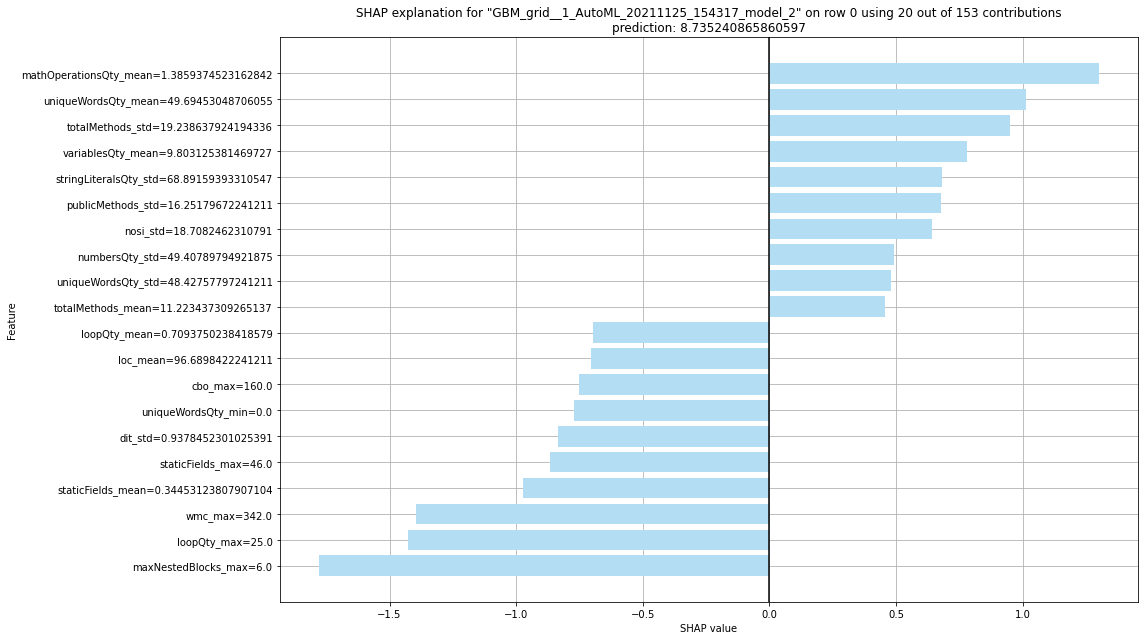

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

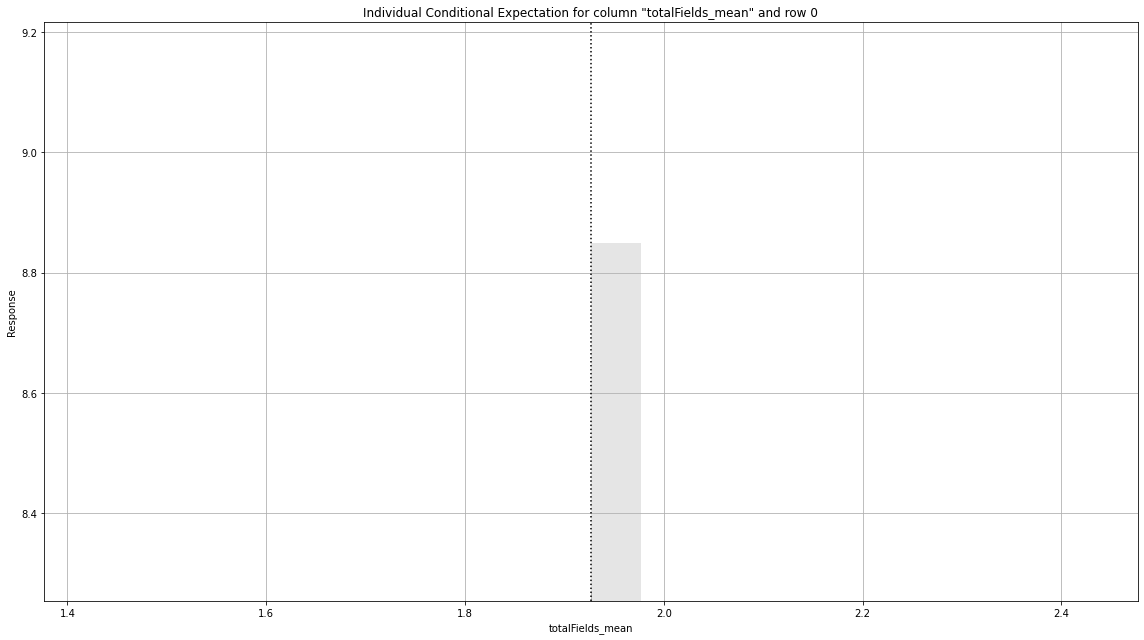

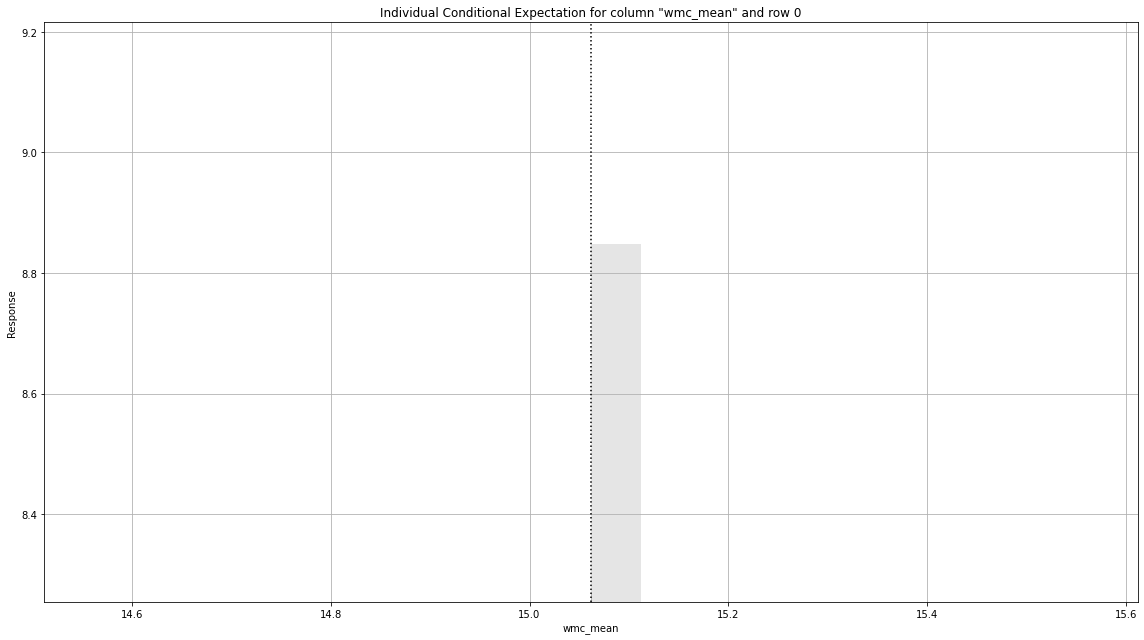

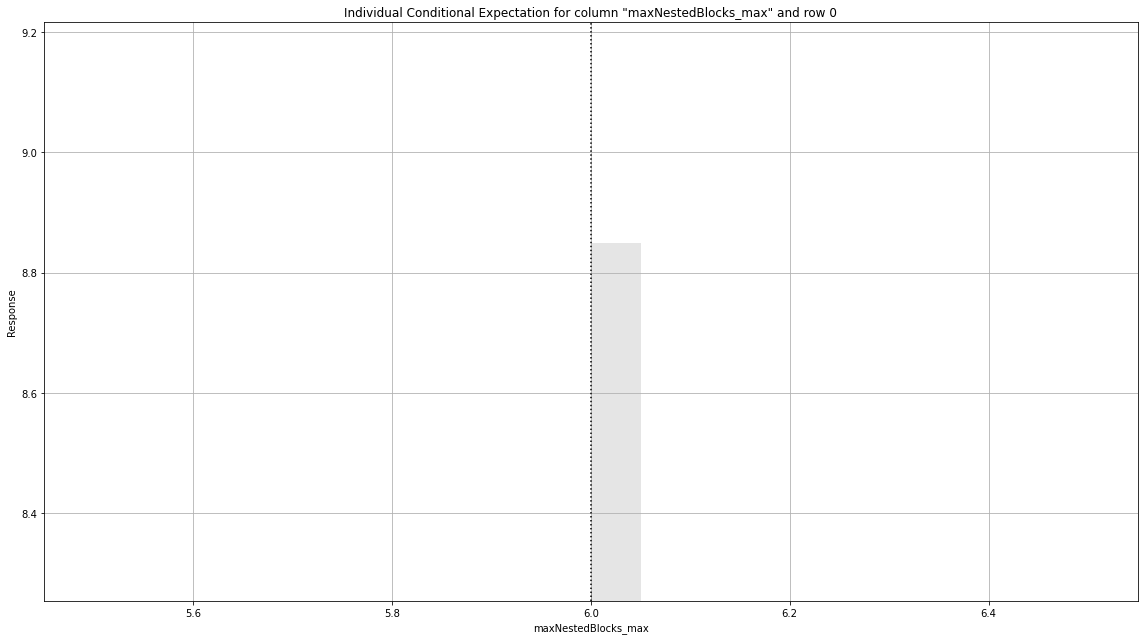

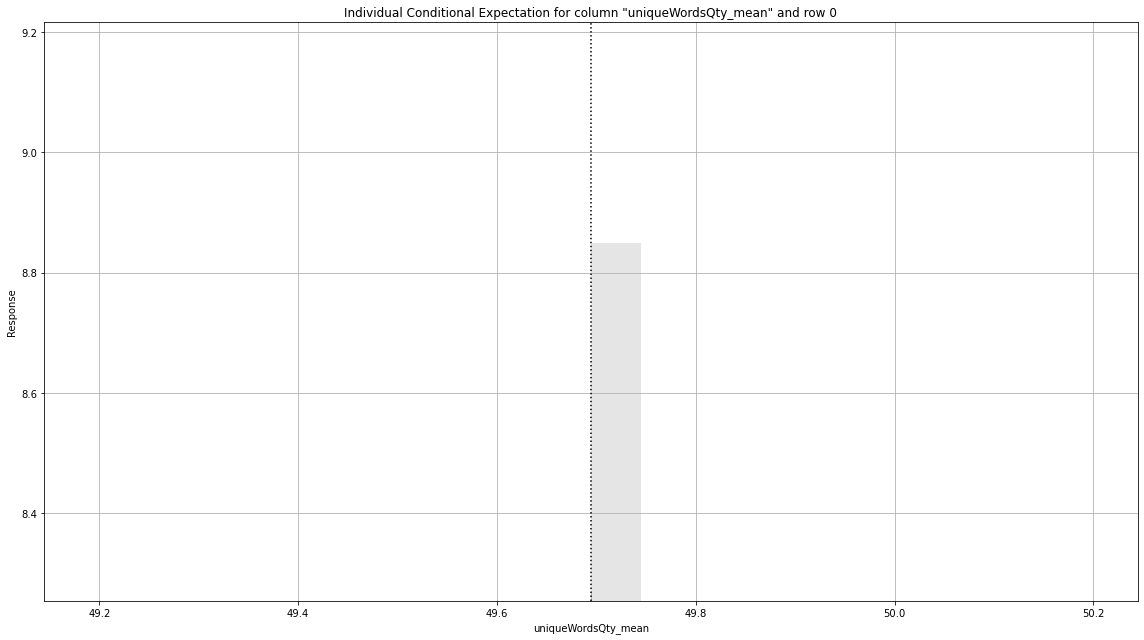

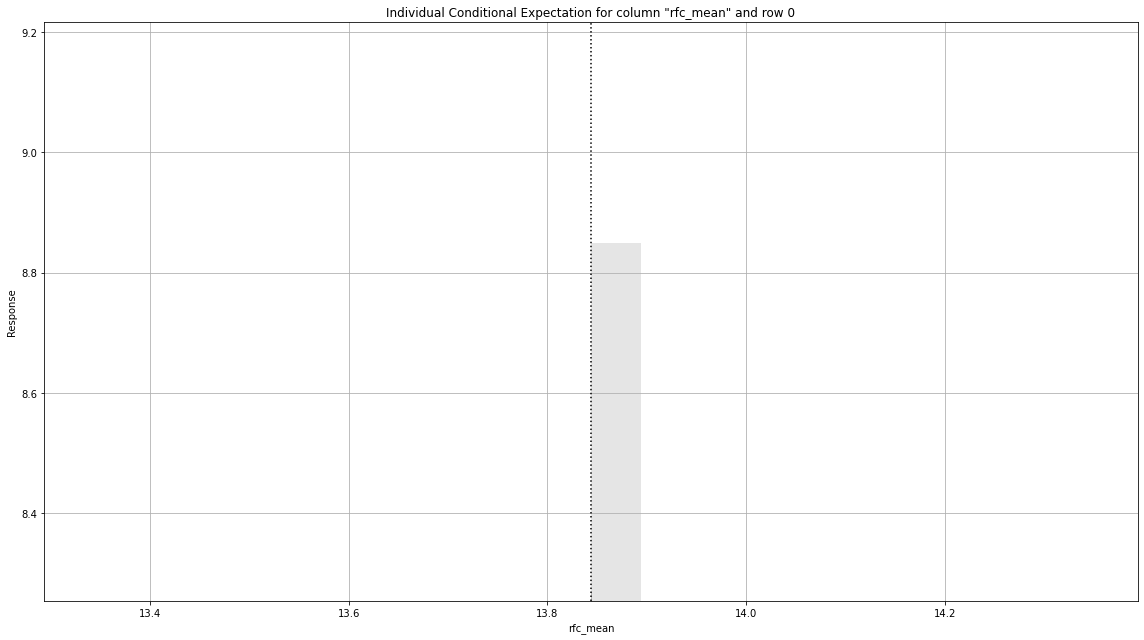

In [36]:
final_df = prediction_df
final_df['time_taken_final'] = preds[0]
exm = saved_model.explain_row(prediction_df, row_index=0)

In [115]:
len(preds)

366

In [116]:
pd_preds = preds.as_data_frame()

In [117]:
pd_preds['predict'].value_counts()

18.775940    2
16.259852    2
4.799652     2
20.734580    2
20.558679    2
            ..
20.994492    1
14.732429    1
18.621463    1
15.743354    1
8.801486     1
Name: predict, Length: 361, dtype: int64